In [1]:
import subprocess
import numpy as np 
import matplotlib.pyplot as plt 
import csv 
import tree as t
from functools import reduce
import pandas as pd
import copy

In [2]:
# high level path info/utils
REF = "/Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa"
REFNAME = "chr21"
OUTDIR = "/Users/rfeld/Documents/Research/SPATIAL/output"
READ_PREFIX = "h"
SEQ_PREFIX = "h"

In [3]:
# make directory and set up file structure 
seqdir = f'{OUTDIR}/{REFNAME}/sequences/{SEQ_PREFIX}'
readdir = f'{OUTDIR}/{REFNAME}/reads/{READ_PREFIX}'
subprocess.call(["mkdir", "-p", seqdir])
subprocess.call(["mkdir", "-p", readdir])

0

In [6]:
# cnasim specs
cnasim_dict = {
    "n": 2, 
    "m": 0, 
    "j": 1, 
    "k": 960,
    "block_length": 60
}
numcells = 2
mode = 0
founder_mult = 1
resolution = 960 #FIXME for alignment with current ref sequence ease (easy fix)

In [7]:
# currently single-allele referencing
cna_call = f"cnasim -m {mode} -n {numcells} -r1 {REF} -o {seqdir} -j {founder_mult} -k {resolution}"
subprocess.run(cna_call.split())

Output directory: /Users/rfeld/Documents/Research/SPATIAL/output/chr21/sequences/h
Preparing ground truth tree...
Initializing reference genome...
Number of chromosomes in reference: 1
Generating genomes, events, and profiles...
Formating and saving profiles


CompletedProcess(args=['cnasim', '-m', '0', '-n', '2', '-r1', '/Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa', '-o', '/Users/rfeld/Documents/Research/SPATIAL/output/chr21/sequences/h', '-j', '1', '-k', '960'], returncode=0)

In [113]:
with open(f'{seqdir}/tree.nwk', "r") as f:
    nwk_string = f.readline()
nwk_tree = t.parse_newick_structure(nwk_string)

# flatten for list access 
cells_flattened = []
traversal = t.parse_newick_structure(nwk_string)
def _recursive_traversal(t):
    if len(t) == 0:
        return []
    elif type(t[-1]) == str:
        return [t[-1]] + _recursive_traversal(t[:-1])
    else:
        return _recursive_traversal(t[-1]) + _recursive_traversal(t[:-1])

cells_flattened = _recursive_traversal(nwk_tree)

print(traversal)

[[['cell1', ['cell4', 'cell5'], 'ancestor3'], 'ancestor1', ['cell2', 'cell3'], 'ancestor2'], 'founder']


In [ ]:
# process focal, choose a cell #FIXME something less manual
def read_focal(fname, cells):
    # cell names 
    out = dict([(c, []) for c in cells])
    # read in
    raw_focal = []
    with open(fname, "r") as f:
        reader = csv.reader(f, delimiter = '\t')
        for row in reader:
            raw_focal.append(row)

    for row in raw_focal[1:]:
        out[row[0]].append(row[2:])
    return out

focal_loc = f'{seqdir}/focal_events.tsv'
focal = read_focal(focal_loc, cells_flattened)

In [115]:
traversal = t.parse_newick_structure(nwk_string)
# --- PRIMARY ROOT CONSTRUCTION ---
# root = t.Cell(traversal[-1])

# store sequence for root 
with open(REF, "r") as f:
    ref = []
    for row in f:
        ref.append(row.strip())
ref = ref[1:]

# join rows by resolution
_rows_per_res = resolution // len(ref[0])
_num_groups = len(ref) // _rows_per_res 
_left_groups = len(ref) % _rows_per_res

_ref = []
for i in range(_num_groups):
    _ref.append(''.join(ref[i * _rows_per_res : (i + 1) * _rows_per_res]))
if _left_groups != 0:
    _ref.append(''.join(ref[-_left_groups:]))

SEQLEN = len(_ref) * resolution

In [116]:
def build_tree(traversal, focal):
    """
    Build a tree from a right-to-left traversal list.
    
    At each level the list is assumed to consist of one or more groups encoded as:
    
       [ immediate_children, parent ]
    
    where immediate_children is exactly the element immediately to the left of the parent's name.
    (If that element is a list of strings, it yields leaf nodes; if it is a mixed list,
    it is processed recursively in the same way.) Any elements further left form another group
    at the same level.
    
    The root is given as the last element of the overall traversal.
    """
    # Create the root (founder)
    root_name = traversal[-1]
    root = t.Cell(cellname=root_name)

    celldict = {root_name: root}
    
    def _populate_mutations(node, focal):
        _id = 0
        for row in focal.get(node.cellname, []):
            allele = int(row[0])
            tumor_start = int(row[1]) - 1
            ref_start = int(row[2]) - 1
            length = int(row[3])
            copies = int(row[4] == "gain") * (1 + int(row[5]))
            node.mutations.append(t.Mutation(
                edgeid=f'{node.cellname}.{_id}',
                allele=allele,
                num_copies=copies,
                relstart=tumor_start,
                refstart=ref_start,
                length=length,
                d=cnasim_dict))
            _id += 1
    _populate_mutations(root, focal)
    def _process_group(lst, parent):
        """
        Process a list 'lst' assumed to encode one or more groups.
        Returns nothing (nodes are attached to parent).
        """
        i = len(lst) - 1
        while i >= 0:
            # The parent's name is always at the end of a group.
            # If we have at least two elements, then lst[i] is the parent's name
            # and lst[i-1] is its immediate children.
            if i - 1 >= 0:
                group_parent = lst[i]  # Expected to be a string
                children_elem = lst[i-1]
                # Create the parent node for this group:
                parent_node = t.Cell(cellname=group_parent, parent=parent, founder=root)
                _populate_mutations(parent_node, focal)
                parent.children.append(parent_node)
                celldict[group_parent] = parent_node
                # Now, process the immediate children.
                if isinstance(children_elem, list):
                    # If it's a pure list of strings, create leaves.
                    if all(isinstance(x, str) for x in children_elem):
                        for child_name in children_elem:
                            child = t.Cell(cellname=child_name, parent=parent_node, founder=root)
                            _populate_mutations(child, focal)
                            parent_node.children.append(child)
                            celldict[child_name] = child
                    else:
                        # Mixed list: process recursively.
                        _process_group(children_elem, parent_node)
                elif isinstance(children_elem, str):
                    # A single leaf.
                    child = t.Cell(cellname=children_elem, parent=parent_node, founder=root)
                    _populate_mutations(child, focal)
                    parent_node.children.append(child)
                    celldict[children_elem] = child
                else:
                    raise ValueError("Unexpected type in group (expected list or string).")
                i -= 2  # We've consumed this group.
            else:
                # If there's a leftover element that doesn't form a complete group, treat it as a leaf.
                elem = lst[i]
                if isinstance(elem, str):
                    leaf = t.Cell(cellname=elem, parent=parent, founder=root)
                    _populate_mutations(leaf, focal)
                    parent.children.append(leaf)
                    celldict[elem] = leaf
                elif isinstance(elem, list):
                    # Process the list as a pure group of leaves.
                    for s in elem:
                        leaf = t.Cell(cellname=s, parent=parent, founder=root)
                        _populate_mutations(leaf, focal)
                        parent.children.append(leaf)
                        celldict[elem] = leaf
                i -= 1

    def _recursive_build(subtree, parent):
        """
        Process a subtree level.
        If the subtree is a pure list of strings, attach them as leaves.
        Otherwise, treat the subtree as one or more groups.
        """
        if isinstance(subtree, list) and all(isinstance(x, str) for x in subtree):
            # Pure list of leaves.
            for s in subtree:
                leaf = t.Cell(cellname=s, parent=parent, founder=root)
                _populate_mutations(leaf, focal)
                parent.children.append(leaf)
        elif isinstance(subtree, list):
            _process_group(subtree, parent)
        else:
            # Not a list: it should be a string.
            leaf = t.Cell(cellname=subtree, parent=parent, founder=root)
            _populate_mutations(leaf, focal)
            parent.children.append(leaf)
    
    # The main traversal's first element is the top-level subtree.
    _recursive_build(traversal[0], root)
    return root, celldict

# Build the tree
root, celldict = build_tree(traversal, focal)

# Function to print tree structure
def print_tree(node, level=0):
    print("  " * level + node.cellname)
    for child in node.children:
        print_tree(child, level + 1)

root.ref = _ref
print_tree(root)
print(celldict.keys())


founder
  ancestor2
    cell2
    cell3
  ancestor1
    ancestor3
      cell4
      cell5
    cell1
dict_keys(['founder', 'ancestor2', 'cell2', 'cell3', 'ancestor1', 'ancestor3', 'cell4', 'cell5', 'cell1'])


In [117]:
cell = celldict['cell3']
allele = 0

cell.all_mutations(allele)


[Mutation(edgeid='founder.0', allele=0, num_copies=0, relstart=32008320, refstart=32007360, length=687360, d={'n': 5, 'm': 0, 'j': 1, 'k': 960, 'block_length': 60}),
 Mutation(edgeid='founder.1', allele=0, num_copies=2, relstart=29180160, refstart=29179200, length=7659840, d={'n': 5, 'm': 0, 'j': 1, 'k': 960, 'block_length': 60}),
 Mutation(edgeid='ancestor2.0', allele=0, num_copies=3, relstart=29766720, refstart=29765760, length=1870080, d={'n': 5, 'm': 0, 'j': 1, 'k': 960, 'block_length': 60})]

In [118]:
def check_non_overlapping(cell, allele):
    ms = cell.all_mutations(allele)

    if len(ms) <= 1:
        return ms
    
    # Create intervals (start, end) and keys (i, i)
    vals = [(m.relstart, m.relstart + m.num_copies * m.length) for m in ms]
    parents = [m.edgeid.split('.')[0] for m in ms]
    keys = [(i, i) for i in range(len(ms))]
    
    # Zip and flatten by sorting on interval points
    zipped = list(zip(vals, keys))
    flat = sorted([(point, i) for (start, end), (i, _) in zipped for point in (start, end)])
    
    # Identify non-overlapping indices
    non_overlapping = set()
    last_id = None
    for _, i in flat:
        if i == last_id:
            non_overlapping.add(i)  # If i appears back-to-back, it's non-overlapping
        last_id = i
    
    return [ms[i] for i in non_overlapping]  # Return sorted list of non-overlapping indices

candidates = dict()
for cell_name in celldict.keys():
    cell = celldict[cell_name]
    no_0 = check_non_overlapping(cell, 0)
    no_1 = check_non_overlapping(cell, 1)
    non_overlapping = no_1 + no_0 
    candidates[cell_name] = non_overlapping[::]

In [119]:
flattened_candidates = [m for cellms in candidates.values() for m in cellms]
sorted_candidates = sorted(flattened_candidates, key = lambda m: m.length * m.num_copies)

In [120]:
# target insertions for now
insertions = [sc for sc in sorted_candidates if sc.num_copies != 0]

In [121]:
# derived values for tm
tm = insertions[0]
tm_cellname = tm.edgeid.split('.')[0]
tm_allele = tm.allele 
relloc = (tm.relstart, tm.relstart + tm.length * tm.num_copies)
BUFFER = 100000 #CHECK: should be sufficient given size of reads
#FIXME should probably compute length of mutated sequence
_left, _right = max(0, relloc[0] - BUFFER), relloc[1] + BUFFER

tm_seq = celldict[tm_cellname].sequence(tm_allele)

In [122]:
tm

Mutation(edgeid='cell5.0', allele=0, num_copies=2, relstart=24407040, refstart=20274240, length=504960, d={'n': 5, 'm': 0, 'j': 1, 'k': 960, 'block_length': 60})

In [123]:
# write cell sequence, along with smaller subsequence
# FIXME generalize out of single (probably call this fn)
def writefa(filedir, seq, cellname, allele, targets = []):
    with open(f'{filedir}/{cellname}.{allele}.fa', "w") as f:
        f.write(f">{cellname}.{allele}\n")
        for line in seq:
            f.write(line + "\n")
    
    if len(targets) > 0:
        for target in targets:
            left = target[0] // resolution ; right = target[1] // resolution
            l = left * resolution; r = right * resolution 

            augmented_filepath = f'{filedir}/{cellname}.{allele}.{l}.{r}.fa'
            with open(augmented_filepath, "w") as f:
                f.write(f">{cellname}.{allele}.{l}.{r}\n")
                for line in seq[left:right]:
                    f.write(line + "\n")
    return f'{filedir}/{cellname}.{allele}.fa', augmented_filepath
filedir = f'{OUTDIR}/{REFNAME}/sequences/{SEQ_PREFIX}'
fp, aug_fp = writefa(filedir, tm_seq, tm_cellname, tm_allele, [(_left, _right)])

In [124]:
NUMREADS = 100
READLEN = 100
OUTERDIST = 250 
samtools = "/Users/rfeld/Documents/Research/SPATIAL/spatial_24/DWGSIM/samtools/samtools"

In [125]:
# Generate Reads
READ1 = f"{readdir}/{READ_PREFIX}.bwa.read1.fastq"
READ2 = f"{readdir}/{READ_PREFIX}.bwa.read2.fastq"
READMODE = 1

# readprocessing = [
#     f"dwgsim -N {NUMREADS} -1 {READLEN} -2 {READLEN} -d {OUTERDIST} -S 1 {aug_fp} {READ_PREFIX}",
#     f"gunzip {READ1}", f"gunzip {READ2}", 
#     f"bwa mem {REF} {READ1} {READ2} > {readdir}/target_{tm.edgeid}.sam",
#     f"{samtools} view -bT {REF} {readdir}/target_{tm.edgeid}.sam > {readdir}/target_{tm.edgeid}.bam",
#     f"{samtools} sort {readdir}/target_{tm.edgeid}.bam > {readdir}/target_{tm.edgeid}_sorted"
#     ]
line =f"dwgsim -N {NUMREADS} -1 {READLEN} -2 {READLEN} -d {OUTERDIST} -S {READMODE} {aug_fp} {READ_PREFIX}"
# readprocessing = [
#     f"dwgsim -N {NUMREADS} -1 {READLEN} -2 {READLEN} -d {OUTERDIST} -S 1 {aug_fp} {READ_PREFIX}",
#     f"bwa mem {REF} {READ1} {READ2} > {readdir}/target_{tm.edgeid}.sam",
#     f"{samtools} view -bT {REF} {readdir}/target_{tm.edgeid}.sam > {readdir}/target_{tm.edgeid}.bam",
#     f"{samtools} sort {readdir}/target_{tm.edgeid}.bam > {readdir}/target_{tm.edgeid}_sorted.bam"
#     ]
subprocess.call(line, shell = True, cwd=readdir)

[dwgsim_core] cell5.0.24306240.25516800 length: 1210560
[dwgsim_core] 1 sequences, total length: 1210560
[dwgsim_core] Currently on: 
[dwgsim_core] 100
[dwgsim_core] Complete!


0

In [131]:
def _compute_lr(mode):
    if mode == 0:
        pass
    elif mode == 1:
        def compute_lr(row):
            if row["strand"] == 1:
                l = row["pos"]; r = row["mpos"]
            else:
                l = row["mpos"]; r = row["pos"]
            return pd.Series({"l": l, 
                              "r": r})
    elif mode == 2:
        pass

    return compute_lr

compute_lr = _compute_lr(READMODE)

In [ ]:
import subprocess
import gzip
import os

# Define input and output files
cwd = readdir
read1 = f"{readdir}/{READ_PREFIX}.bwa.read1.fastq.gz"
read2 = f"{readdir}/{READ_PREFIX}.bwa.read2.fastq.gz"
dual_read1 = f"{readdir}/filtered_read1.fastq"
dual_read2 = f"{readdir}/filtered_read2.fastq"
unmapped = f"{readdir}/unmapped.fastq"

def get_read_names(file_path):
    read_names = set()
    with gzip.open(file_path, 'rt') as f:
        while True:
            header = f.readline().strip()
            f.readline()  # seq
            f.readline()  # plus
            f.readline()  # qual
            if not header:
                break
            if header.startswith(f"@{tm_cellname}"):  # Mapped reads
                read_name = header.split()[0].replace("/1", "").replace("/2", "")
                read_names.add(read_name)
    return read_names

# 1. Extract read names from both files
print("Extracting read names...")
read1_names = get_read_names(read1)
read2_names = get_read_names(read2)

# 2. Identify dually mapped and unmapped reads
dually_mapped = read1_names & read2_names
unmapped_reads = (read1_names | read2_names) - dually_mapped

print(f"Found {len(dually_mapped)} dually mapped reads.")
print(f"Found {len(unmapped_reads)} unmapped reads.")

# 3. Function to filter reads
def filter_reads(input_file, output_file, names_to_keep):
    with gzip.open(input_file, 'rt') as f_in, open(output_file, 'w') as f_out:
        while True:
            header = f_in.readline()
            seq = f_in.readline()
            plus = f_in.readline()
            qual = f_in.readline()
            if not header:
                break
            read_name = header.strip().split()[0].replace("/1", "").replace("/2", "")
            if read_name in names_to_keep:
                f_out.write(header + seq + plus + qual)

# 4. Filter dually mapped reads
print("Filtering dually mapped reads...")
filter_reads(read1, dual_read1, dually_mapped)
filter_reads(read2, dual_read2, dually_mapped)

# 5. Filter unmapped reads (combine both ends)
print("Filtering unmapped reads...")
with open(unmapped, 'w') as f_out:
    filter_reads(read1, f_out.name, unmapped_reads)
    filter_reads(read2, f_out.name, unmapped_reads)

Extracting read names...
Found 97 dually mapped reads.
Found 0 unmapped reads.
Filtering dually mapped reads...
Filtering unmapped reads...


In [128]:
readprocessing2 = [
    f"bwa mem {REF} {dual_read1} {dual_read2} > {readdir}/target_{tm.edgeid}.sam",
    f"{samtools} view -bT {REF} {readdir}/target_{tm.edgeid}.sam > {readdir}/target_{tm.edgeid}.bam",
    f"{samtools} sort {readdir}/target_{tm.edgeid}.bam > {readdir}/target_{tm.edgeid}_sorted.bam",
    f'{samtools} view -F 4 -f 8 {readdir}/target_{tm.edgeid}.bam |' + " awk '{print $1, $2, $4, $8, $5}' > lmapped.txt",
    f'{samtools} view -F 8 -f 4 {readdir}/target_{tm.edgeid}.bam |'  " awk '{print $1, $2, $4, $8, $5}' > rmapped.txt",
    f'{samtools} view -f 0x2 {readdir}/target_{tm.edgeid}.bam |' + " awk '{print $1, $2, $4, $8, $5}' > fullmapped.txt"]


for line in readprocessing2:
    subprocess.call(line, shell = True, cwd=readdir)

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 194 sequences (19400 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 93)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (113, 147, 196)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 362)
[M::mem_pestat] mean and std.dev: (149.90, 53.65)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 445)
[M::mem_process_seqs] Processed 194 reads in 0.026 CPU sec, 0.028 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/chr21/reads/h/filtered_read1.fastq /Users/rfeld/Documents/Resea

In [132]:
#FIXME no underscores in name - dots only for field parsing alignment
import pandas as pd
data = f"{readdir}/fullmapped.txt"
df = pd.read_csv(data, sep = " ", header = None, 
                 names=["read_name", "flag", "pos", "mpos", "mapq"])

df["flag"] = df["flag"].apply(lambda x: bin(x)[2:].zfill(11))
cols = df["flag"].apply(list)


bnames = ["paired", "proper", "unmapped_q", "mate_unmapped", "strand", "mate_strand",
          "first_read", "second_read", "not_prim", "QC", "op_PCR"][::-1]
df = pd.concat([df, pd.DataFrame(cols.tolist(), columns = bnames).astype(int)], axis = 1)
df.drop(['flag', 'QC', 'op_PCR', 'not_prim'],
         axis = 1, inplace = True)

unpaired_df = df[df["proper"] == 0]
df = df[df["proper"] == 1] 
df = df[df["first_read"] == 1]
df[["l", "r"]] = df.apply(compute_lr, axis = 1)
df.head()

,read_name,pos,mpos,mapq,second_read,first_read,mate_strand,strand,mate_unmapped,unmapped_q,proper,paired,l,r
0,cell5.0.24306240.25516800_646273_646333_1_1_0_...,20314753,20314813,60,0,1,1,1,0,0,1,1,20314753,20314813
2,cell5.0.24306240.25516800_406457_406237_0_0_0_...,20579897,20579677,60,0,1,0,0,0,0,1,1,20579677,20579897
4,cell5.0.24306240.25516800_493079_492938_0_0_0_...,20666519,20666378,60,0,1,0,0,0,0,1,1,20666378,20666519
6,cell5.0.24306240.25516800_920782_920832_1_1_0_...,20589262,20589312,60,0,1,1,1,0,0,1,1,20589262,20589312
8,cell5.0.24306240.25516800_849924_849857_0_0_0_...,20518404,20518337,60,0,1,0,0,0,0,1,1,20518337,20518404


In [136]:
threshold = 500 # check
sus_df = df[(df["l"] > df["r"]) | (df["r"] - df["l"] > threshold)]

In [137]:
sus_df

,read_name,pos,mpos,mapq,second_read,first_read,mate_strand,strand,mate_unmapped,unmapped_q,proper,paired,l,r


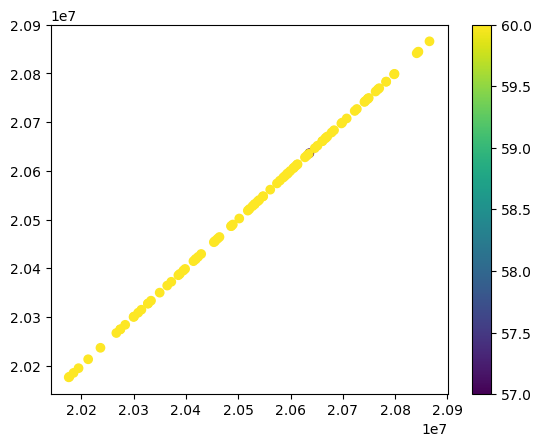

In [140]:
sampled_df = df
plt.scatter(sampled_df["l"], sampled_df["r"], c = sampled_df["mapq"])
plt.colorbar()
plt.show()